# Lymphocytosis Dataset - Exploration and Splitting

In [19]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from os import path
import pandas as pd
from pathlib import Path
import random
from time import time
import torch
from torch import Tensor
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import Compose
from torch.utils.data import Dataset, DataLoader
from typing import List

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Exploration and first preprocessing

In [4]:
# Load the complete dataset
lymph_df = pd.read_csv('/content/drive/MyDrive/DLMI/challenge/data/clinical_annotation.csv', sep=',')

lymph_df.style

,Unnamed: 0,ID,LABEL,GENDER,DOB,LYMPH_COUNT
0,0,P26,1,M,11/3/1933,11.200000
1,1,P183,1,M,5/15/1942,12.800000
2,2,P89,1,M,6/19/1935,9.600000
3,3,P123,1,M,1/27/1931,122.600000
4,4,P61,1,F,3/5/1931,11.600000
5,5,P112,1,F,5/9/1946,22.100000
6,6,P71,-1,M,1/17/1946,5.760000
7,7,P63,0,F,7/20/1997,6.300000
8,8,P184,1,F,6/12/1932,220.000000
9,9,P16,-1,M,3/5/1940,32.000000


In [5]:
def data_preprocessing(lymph_df: pd.DataFrame) -> pd.DataFrame:
  n = lymph_df.shape[0]
  ages = np.zeros(n)
  genders = np.zeros(n)

  for i in range(n):
    # Extract age from DOB
    date_of_birth = lymph_df.DOB[i]
    if '/' in date_of_birth:
      year = date_of_birth.split('/')[-1]
    elif '-' in date_of_birth:
      year = date_of_birth.split('-')[-1]

    # We do not have information of the year of the data acquisition so we will assume it was this year.
    # It shouldn't be relevant as it just represents an additive bias.
    ages[i] = 2024 - int(year)

    # Encode gender
    alph_gender = lymph_df.GENDER[i]
    if alph_gender == 'F' or alph_gender == 'f':
      genders[i] = 1
    elif alph_gender == 'M' or alph_gender == 'm':
      genders[i] = 0

  lymph_df_out = lymph_df.drop(columns='GENDER')
  lymph_df_out.insert(3, 'GENDER', genders)
  lymph_df_out = lymph_df_out.drop(columns='DOB')
  lymph_df_out.insert(4, 'AGE', ages)

  return lymph_df_out

lymph_df_modified = data_preprocessing(lymph_df)
lymph_df_modified.style

,Unnamed: 0,ID,LABEL,GENDER,AGE,LYMPH_COUNT
0,0,P26,1,0.000000,91.000000,11.200000
1,1,P183,1,0.000000,82.000000,12.800000
2,2,P89,1,0.000000,89.000000,9.600000
3,3,P123,1,0.000000,93.000000,122.600000
4,4,P61,1,1.000000,93.000000,11.600000
5,5,P112,1,1.000000,78.000000,22.100000
6,6,P71,-1,0.000000,78.000000,5.760000
7,7,P63,0,1.000000,27.000000,6.300000
8,8,P184,1,1.000000,92.000000,220.000000
9,9,P16,-1,0.000000,84.000000,32.000000


In [6]:
def characteristics_table(df: pd.DataFrame, merged_df: pd.DataFrame) -> pd.DataFrame:
    """Creates a DataFrame that summarizes the characteristics of the DataFrame df"""
    labels = np.unique(df.LABEL.values)
    population_df = pd.DataFrame(index=labels,
                                columns=['N', '%sexF', 'age',
                                         'lymph_count'])
    merged_df = merged_df.set_index(['ID'], drop=True)
    df = df.set_index(['ID'], drop=True)
    sub_merged_df = merged_df.loc[df.index]

    for label in population_df.index.values:
        labels_df = sub_merged_df[df.LABEL == label]
        population_df.loc[label, 'N'] = len(labels_df)
        # Age
        mean_age = np.mean(labels_df.AGE)
        std_age = np.std(labels_df.AGE)
        population_df.loc[label, 'age'] = '%.1f ± %.1f' % (mean_age, std_age)
        # Sex
        population_df.loc[label, '%sexF'] = round((len(labels_df[labels_df.GENDER == 1]) / len(labels_df)) * 100, 1)
        # Lymph_count
        mean_LC = np.mean(labels_df.LYMPH_COUNT)
        std_LC = np.std(labels_df.LYMPH_COUNT)
        population_df.loc[label, 'lymph_count'] = '%.1f ± %.1f' % (mean_LC, std_LC)

    return population_df

population_df = characteristics_table(lymph_df_modified, lymph_df_modified)
population_df.style

,N,%sexF,age,lymph_count
-1,42,42.900000,69.7 ± 19.5,24.4 ± 43.6
0,50,52.000000,58.3 ± 19.6,5.0 ± 1.0
1,113,48.700000,79.2 ± 12.0,35.9 ± 53.3


Text(0.5, 1.0, 'Lymph Count Distribution')

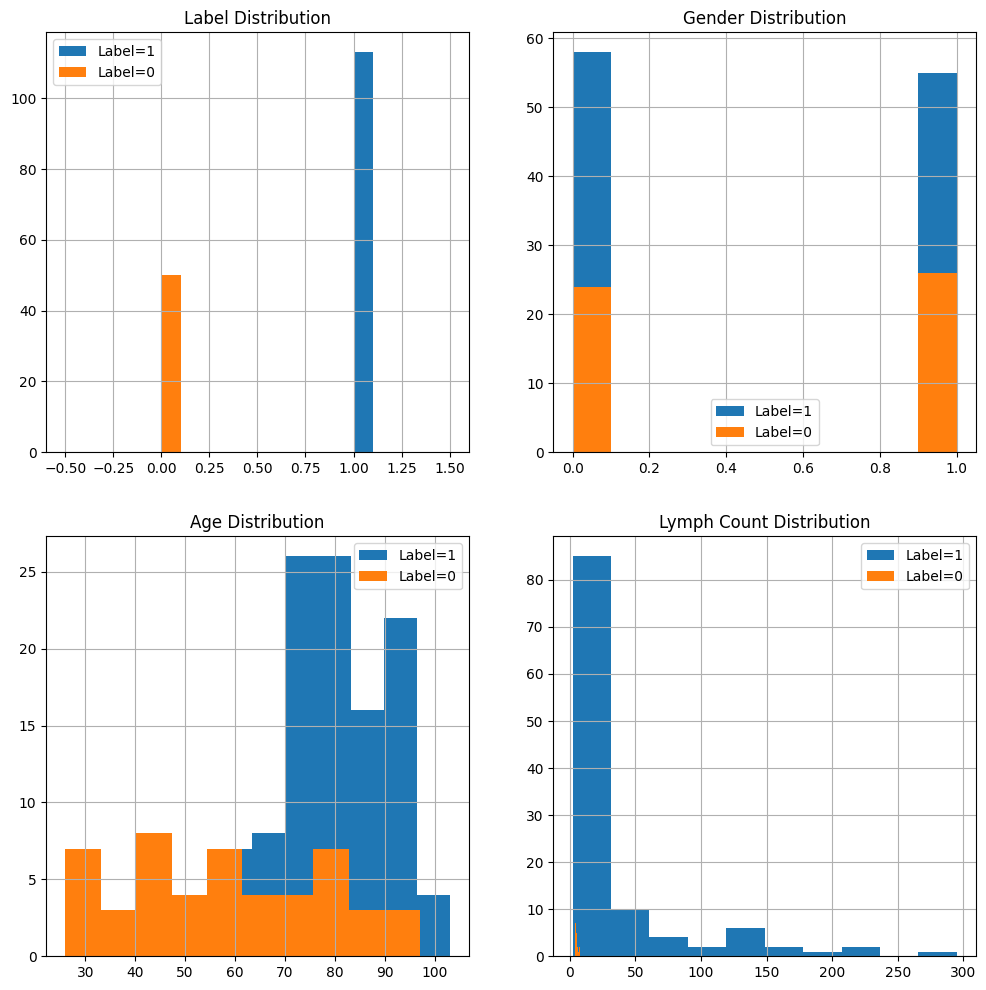

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

lymph_df_modified['LABEL'][lymph_df_modified['LABEL']==1].hist(ax=axs[0,0], label='Label=1')
lymph_df_modified['LABEL'][lymph_df_modified['LABEL']==0].hist(ax=axs[0,0], label='Label=0')
axs[0,0].legend()
axs[0,0].set_title('Label Distribution')

lymph_df_modified['GENDER'][lymph_df_modified['LABEL']==1].hist(ax=axs[0,1], label='Label=1')
lymph_df_modified['GENDER'][lymph_df_modified['LABEL']==0].hist(ax=axs[0,1], label='Label=0')
axs[0,1].legend()
axs[0,1].set_title('Gender Distribution')

lymph_df_modified['AGE'][lymph_df_modified['LABEL']==1].hist(ax=axs[1,0], label='Label=1')
lymph_df_modified['AGE'][lymph_df_modified['LABEL']==0].hist(ax=axs[1,0], label='Label=0')
axs[1,0].legend()
axs[1,0].set_title('Age Distribution')

lymph_df_modified['LYMPH_COUNT'][lymph_df_modified['LABEL']==1].hist(ax=axs[1,1], label='Label=1')
lymph_df_modified['LYMPH_COUNT'][lymph_df_modified['LABEL']==0].hist(ax=axs[1,1], label='Label=0')
axs[1,1].legend()
axs[1,1].set_title('Lymph Count Distribution')


In [8]:
### TO DO: check if stratifying on these features is relevant

def digitize_age_lymphs(df: pd.DataFrame) -> pd.DataFrame:
  age = df['AGE']
  age_binned = pd.qcut(age, 2, labels=False)

  lymph_count = df['LYMPH_COUNT']
  count_binned = pd.qcut(lymph_count, 2, labels=False)

  df_out = df.drop(columns='AGE')
  df_out.insert(4, 'AGE', age_binned)
  df_out = df_out.drop(columns='LYMPH_COUNT')
  df_out.insert(5, 'LYMPH_COUNT', count_binned)

  return df_out

lymph_df_modified_2 = digitize_age_lymphs(lymph_df_modified)

Text(0.5, 1.0, 'Lymph Count Distribution')

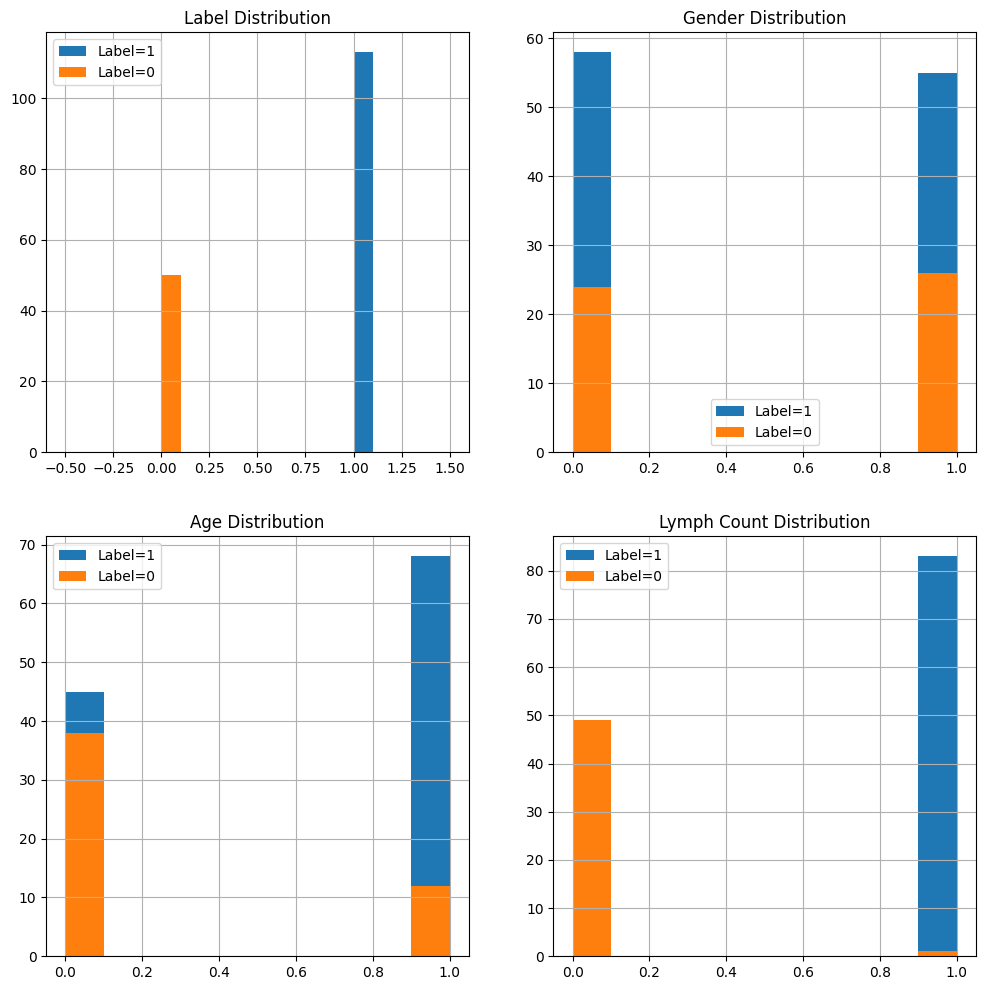

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

lymph_df_modified_2['LABEL'][lymph_df_modified_2['LABEL']==1].hist(ax=axs[0,0], label='Label=1')
lymph_df_modified_2['LABEL'][lymph_df_modified_2['LABEL']==0].hist(ax=axs[0,0], label='Label=0')
axs[0,0].legend()
axs[0,0].set_title('Label Distribution')

lymph_df_modified_2['GENDER'][lymph_df_modified_2['LABEL']==1].hist(ax=axs[0,1], label='Label=1')
lymph_df_modified_2['GENDER'][lymph_df_modified_2['LABEL']==0].hist(ax=axs[0,1], label='Label=0')
axs[0,1].legend()
axs[0,1].set_title('Gender Distribution')

lymph_df_modified_2['AGE'][lymph_df_modified_2['LABEL']==1].hist(ax=axs[1,0], label='Label=1')
lymph_df_modified_2['AGE'][lymph_df_modified_2['LABEL']==0].hist(ax=axs[1,0], label='Label=0')
axs[1,0].legend()
axs[1,0].set_title('Age Distribution')

lymph_df_modified_2['LYMPH_COUNT'][lymph_df_modified_2['LABEL']==1].hist(ax=axs[1,1], label='Label=1')
lymph_df_modified_2['LYMPH_COUNT'][lymph_df_modified_2['LABEL']==0].hist(ax=axs[1,1], label='Label=0')
axs[1,1].legend()
axs[1,1].set_title('Lymph Count Distribution')


### Train-Val Splitting

In order to choose hyperparameters, the set of images is divided into a training set (80%) and a validation set (20%). The data split was performed in order to ensure a similar distribution of diagnosis between the subjects of the training set and the subjects of the validation set.

In [10]:
train_val_df = lymph_df_modified[lymph_df_modified_2['LABEL']!=-1]
test_df = lymph_df_modified[lymph_df_modified_2['LABEL']==-1]

print('# train+val samples: ', train_val_df.shape[0])
print('# test samples: ', test_df.shape[0])

# train+val samples:  163
# test samples:  42


In [11]:
from sklearn.model_selection import train_test_split

X = train_val_df['ID']
y = train_val_df['LABEL']

X_train, X_val, _, _ = train_test_split(X, y,
                                        stratify=train_val_df[['LABEL']],
                                        test_size=0.20)

print(X_train.shape)
print(X_val.shape)

(130,)
(33,)


In [ ]:
train_df = train_val_df[train_val_df['ID'].isin(X_train)]
train_df.drop(columns='Unnamed: 0', inplace=True)
train_df.reset_index(inplace=True)
train_df.to_csv('/content/drive/MyDrive/DLMI/challenge/data/train_set.csv', index=False)

val_df =train_val_df[train_val_df['ID'].isin(X_val)]
val_df.drop(columns='Unnamed: 0', inplace=True)
val_df.reset_index(inplace=True)
val_df.to_csv('/content/drive/MyDrive/DLMI/challenge/data/val_set.csv', index=False)

test_df.drop(columns='Unnamed: 0', inplace=True)
test_df.reset_index(inplace=True)
test_df.to_csv('/content/drive/MyDrive/DLMI/challenge/data/test_set.csv', index=False)

<ipython-input-11-145521209967>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns='Unnamed: 0', inplace=True)
<ipython-input-11-145521209967>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.drop(columns='Unnamed: 0', inplace=True)
<ipython-input-11-145521209967>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns='Unnamed: 0', inplace=True)


In [13]:
train_df = pd.read_csv('/content/drive/MyDrive/DLMI/challenge/data/train_set.csv')
val_df = pd.read_csv('/content/drive/MyDrive/DLMI/challenge/data/val_set.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DLMI/challenge/data/test_set.csv')

Text(0.5, 1.0, 'Lymph Count Distribution')

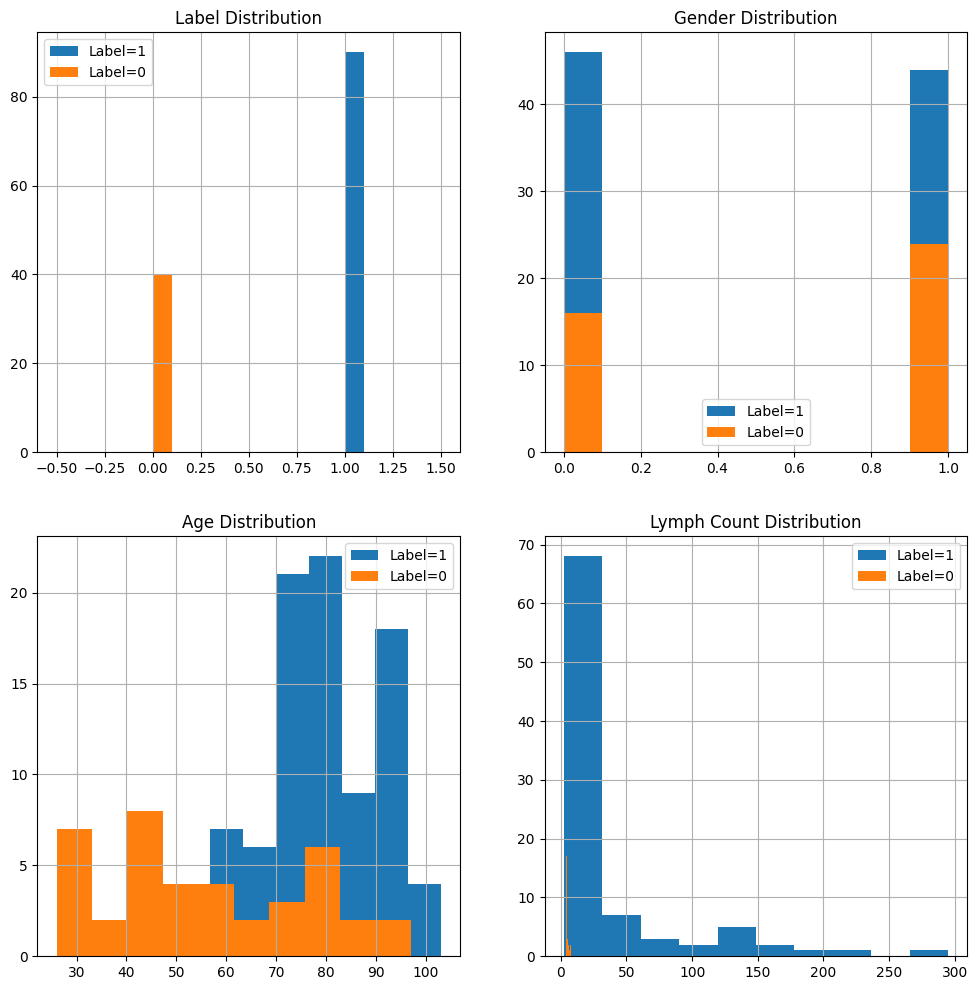

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

train_df['LABEL'][train_df['LABEL']==1].hist(ax=axs[0,0], label='Label=1')
train_df['LABEL'][train_df['LABEL']==0].hist(ax=axs[0,0], label='Label=0')
axs[0,0].legend()
axs[0,0].set_title('Label Distribution')

train_df['GENDER'][train_df['LABEL']==1].hist(ax=axs[0,1], label='Label=1')
train_df['GENDER'][train_df['LABEL']==0].hist(ax=axs[0,1], label='Label=0')
axs[0,1].legend()
axs[0,1].set_title('Gender Distribution')

train_df['AGE'][train_df['LABEL']==1].hist(ax=axs[1,0], label='Label=1')
train_df['AGE'][train_df['LABEL']==0].hist(ax=axs[1,0], label='Label=0')
axs[1,0].legend()
axs[1,0].set_title('Age Distribution')

train_df['LYMPH_COUNT'][train_df['LABEL']==1].hist(ax=axs[1,1], label='Label=1')
train_df['LYMPH_COUNT'][train_df['LABEL']==0].hist(ax=axs[1,1], label='Label=0')
axs[1,1].legend()
axs[1,1].set_title('Lymph Count Distribution')

Text(0.5, 1.0, 'Lymph Count Distribution')

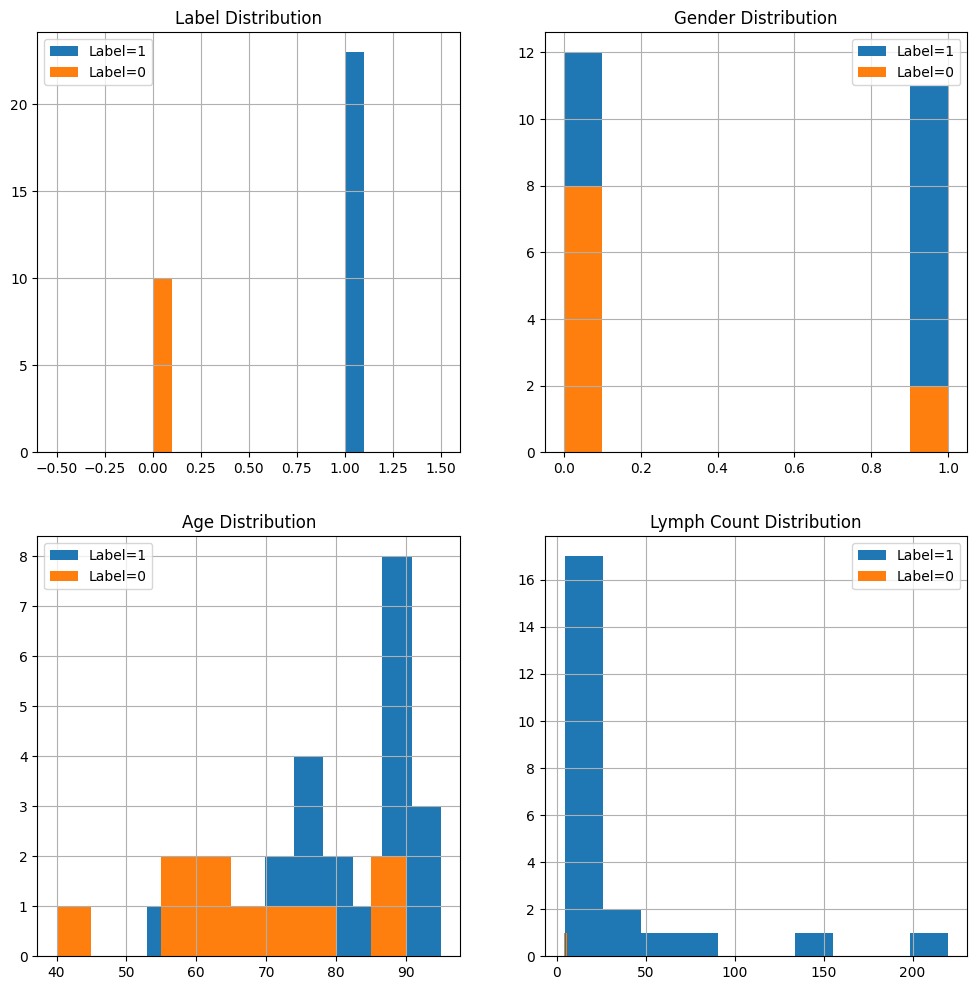

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

val_df['LABEL'][val_df['LABEL']==1].hist(ax=axs[0,0], label='Label=1')
val_df['LABEL'][val_df['LABEL']==0].hist(ax=axs[0,0], label='Label=0')
axs[0,0].legend()
axs[0,0].set_title('Label Distribution')

val_df['GENDER'][val_df['LABEL']==1].hist(ax=axs[0,1], label='Label=1')
val_df['GENDER'][val_df['LABEL']==0].hist(ax=axs[0,1], label='Label=0')
axs[0,1].legend()
axs[0,1].set_title('Gender Distribution')

val_df['AGE'][val_df['LABEL']==1].hist(ax=axs[1,0], label='Label=1')
val_df['AGE'][val_df['LABEL']==0].hist(ax=axs[1,0], label='Label=0')
axs[1,0].legend()
axs[1,0].set_title('Age Distribution')

val_df['LYMPH_COUNT'][val_df['LABEL']==1].hist(ax=axs[1,1], label='Label=1')
val_df['LYMPH_COUNT'][val_df['LABEL']==0].hist(ax=axs[1,1], label='Label=0')
axs[1,1].legend()
axs[1,1].set_title('Lymph Count Distribution')

### Dataset and DataLoader creation

In [20]:
class BagDataset(Dataset):
    """This dataset returns the images and clinical data for each patient."""

    def __init__(self, img_dir: str, data_df: pd.DataFrame, transform: Compose = None) -> None:
        """
        Args:
            img_dir: Path to the images directory.
            data_df: List of subjects used.
            transform: Optional, transformations applied to the tensor.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.data_df = data_df

    def __len__(self) -> int:
        return len(self.data_df)

    def __getitem__(self, idx: int) -> dict[List[Tensor], int, str, float, float, float]:
        """
        Args:
            idx: The index of the subject whose data is loaded.
        Returns:
            sample: corresponding data described by the following keys:
                images: List with image tensors.
                label: The diagnosis code.
                id: ID of the participant.
                gender: 0.0 for male, '1' for female.
                age: Age value.
                lymph_count: Lymph count value.
        """

        label = self.data_df.loc[idx, 'LABEL']
        age = self.data_df.loc[idx, 'AGE']
        gender = self.data_df.loc[idx, 'GENDER']
        lymph_count = self.data_df.loc[idx, 'LYMPH_COUNT']

        id = self.data_df.loc[idx, 'ID']
        folder_name = path.join(self.img_dir, id)
        images = []
        for filename in Path(folder_name).glob('*'):
          image = read_image(str(filename))

          if self.transform:
              image = self.transform(image)
          images.append(image)

        sample = {'images': images, 'label': label,
                  'id': id, 'gender': gender, 'age': age,
                  'lymph_count': lymph_count}
        return sample

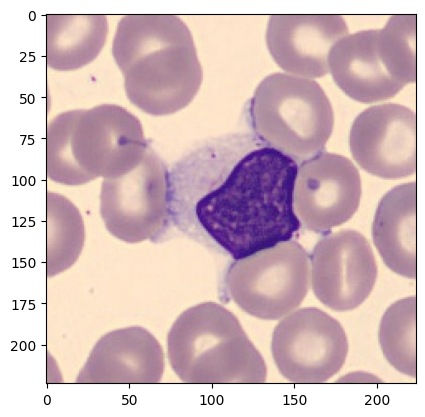

In [21]:
img_path = '/content/drive/MyDrive/DLMI/challenge/data/trainset'
train_dataset = BagDataset(img_path, train_df)
# print(train_dataset.__getitem__(0))
plt.imshow(np.moveaxis(np.array(train_dataset.__getitem__(0)['images'][0]),0,2))

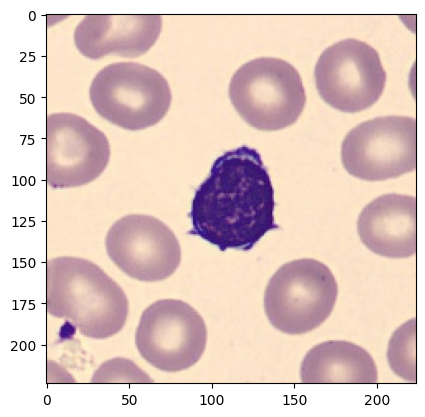

In [22]:
img_path = '/content/drive/MyDrive/DLMI/challenge/data/trainset'
val_dataset = BagDataset(img_path, val_df)
# print(val_dataset.__getitem__(0))
plt.imshow(np.moveaxis(np.array(val_dataset.__getitem__(0)['images'][0]),0,2))

In [23]:
trainloader = DataLoader(dataset=train_dataset, batch_size=128, num_workers=4)
valloader = DataLoader(dataset=val_dataset, batch_size=128, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
